In [1]:
import pandas as pd 
import re
import numpy as np
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

# Corpus is the review text of Health_and_Personal_Care_5 from Amazon

In [2]:
df = pd.read_json('./Health_and_Personal_Care_5.json', lines= True)
corpus = ' '.join(df['reviewText'])
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5,Very nice and convenient.,1313452800,"08 16, 2011"


# Spliting corpus into sentences 

In [3]:
import nltk
# download the punkt tokenizer and split it into sentences 
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

sentences = tokenizer.tokenize(corpus)
stopwords = list(stopwords)

[nltk_data] Downloading package punkt to /home/lisyuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lisyuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Spliting sentences into tokens and remove stopwords

In [5]:
def sentences2tokens(sentences):
    
    pattern = re.compile('[^A-Za-z]+')
    tokens = re.sub(pattern, ' ', sentences)
    tokens = tokens.strip().split()
    sw_token = [word for word in tokens if word not in stopwords]
    return sw_token

In [6]:
tokens = [sentences2tokens(s) for s in sentences ]
print(sentences[40])
print(tokens[40])

This pocket magnifier is nice and compact.
['This', 'pocket', 'magnifier', 'nice', 'compact']


# Training 

In [7]:
workers = cpu_count()
vector_dimension = 300
sg = 1 # 0 for CBOW 1 for skip-grams
min_count = 5 
epochs = 10

In [8]:
model = Word2Vec(size = vector_dimension,min_count = min_count,workers = workers, sg = sg, seed = 1)
model.build_vocab(tokens)
model.train(sentences=tokens, total_examples = model.corpus_count, epochs = epochs)
model.save("word2vec_trained_on_Health_and_Personal_Care_5.w2v")
print("Word2Vec vocabulary length: ", len(model.wv.vocab))
print("training finished")

Word2Vec vocabulary length:  47414
training finished


# Testing the model

In [9]:
w2v = Word2Vec.load("word2vec_trained_on_Health_and_Personal_Care_5.w2v")

In [10]:
wordlimit = 25000 # tsne non-linear prevent too slow 
wv_matrix = np.zeros(shape = (wordlimit, vector_dimension), dtype='float32')
word_list = []
for i, word in enumerate(w2v.wv.vocab):
    wv_matrix[i] = w2v[word]
    word_list.append(word)
    if i == wordlimit-1: break
print(wv_matrix.shape)

(25000, 300)


/home/lisyuan/Lisyuan_Workspace/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
word_tsne = tsne.fit_transform(wv_matrix)
word_tsne.shape

(25000, 2)

In [12]:
import numpy as np 

x_ord = [wv_matrix[i][0] for i in range(len(word_list))]
y_ord = [wv_matrix[i][1] for i in range(len(word_list))]

combined = zip(word_list, x_ord, y_ord)
combined = list(combined)
tsne_df = pd.DataFrame(combined, columns=["token", "x", "y"])
tsne_df.head()

,token,x,y
0,This,-0.219780,-0.058201
1,great,-0.053868,-0.164206
2,little,0.227887,0.105943
3,gadget,-0.082864,-0.063339
4,around,-0.130607,-0.147981


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %matplotlib notebook
sns.set_context("poster")

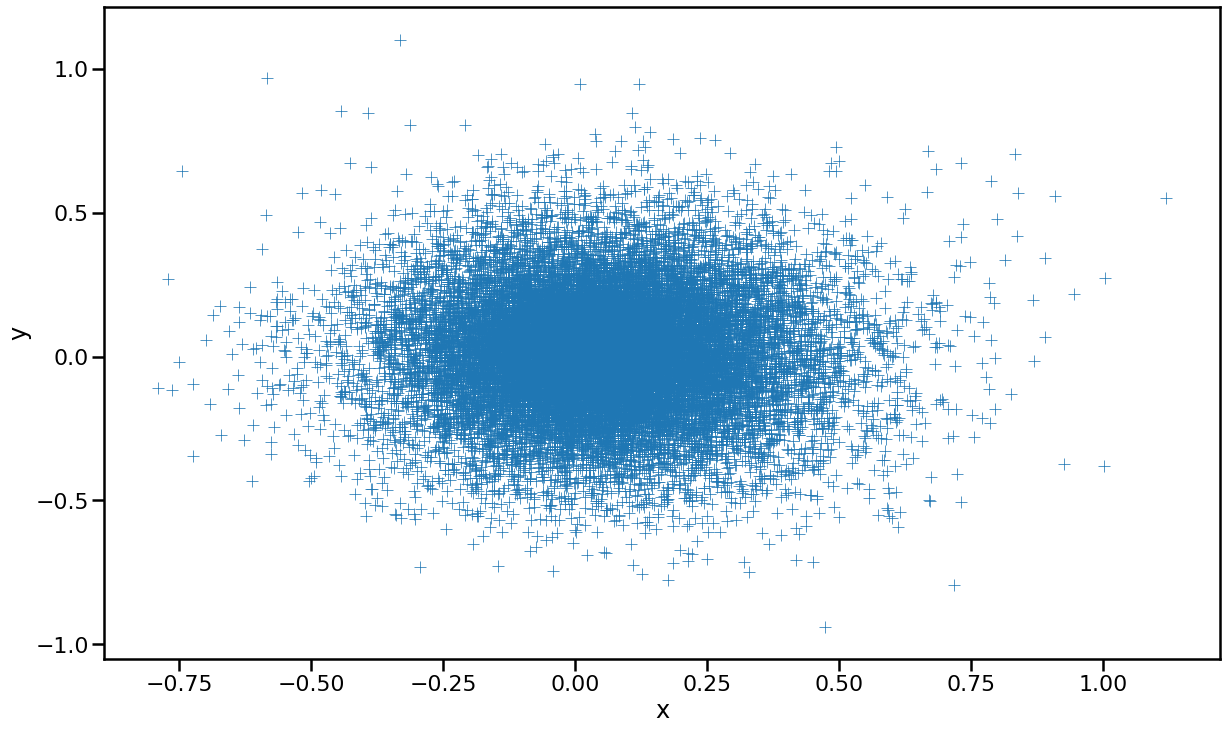

In [14]:
fig, ax = plt.subplots(figsize=(20, 12))

ax = sns.scatterplot(x=tsne_df['x'], y=tsne_df['y'], marker = '+', data=tsne_df)

In [15]:
def plot_region(tsne_df, x_bounds, y_bounds):
    
    region = tsne_df[
        (x_bounds[0] <= tsne_df.x) &
        (tsne_df.x <= x_bounds[1]) &
        (y_bounds[0] <= tsne_df.y) &
        (tsne_df.y <= y_bounds[1]) 
    ]
    
    ax = region.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in region.iterrows():
        ax.text(point.x + 0.0001, point.y + 0.0001, point.token, fontsize=10)

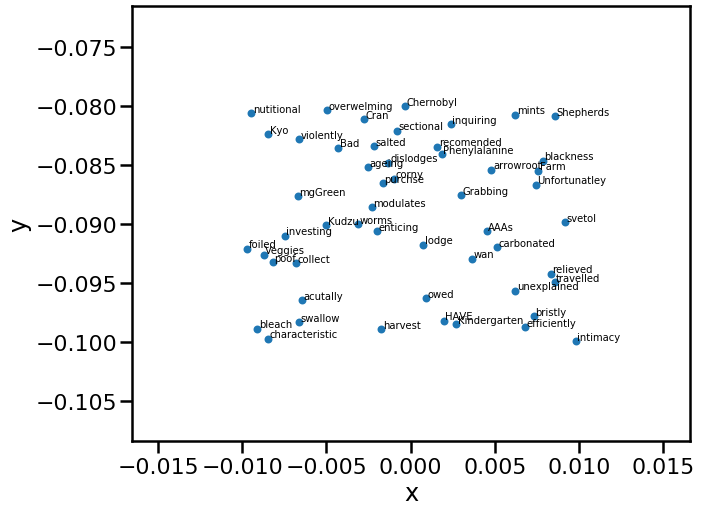

In [18]:
plot_region(tsne_df, x_bounds=(-0.01, 0.01), y_bounds=(-0.10, -0.08))